In [1]:
import os
os.chdir('..')
from PIL import Image
import numpy as np
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from accelerate import Accelerator
from data.datasets import GenerateDataset
from torch.utils.data import DataLoader
from torchvision import transforms
import csv
palette = [[0,0,0],[255,0,0],[180,120,120],[160,150,20],[140,140,140],[61,230,250],[0,82,255],[255,0,245],[255,235,0],[4,250,7]]
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/hice1/athalanki3/.conda/envs/dl_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Setup Dataset
dataset = "GenerateFloodNet"

img_transforms = transforms.Compose([
        transforms.ToTensor()
])
label_transforms = transforms.Compose([
    torch.from_numpy
])
h,w = 512, 512


train_image_dir = f"/home/hice1/athalanki3/scratch/DeepLearningProject/{dataset}/FloodNet-Supervised_v1.0/train/train-org-img"
train_label_dir = f"/home/hice1/athalanki3/scratch/DeepLearningProject/{dataset}/FloodNet-Supervised_v1.0/train/train-label-img"
train_dataset = GenerateDataset(train_image_dir,train_label_dir,h,w,palette,transform=img_transforms,target_transform=label_transforms)

In [3]:
#Setup Model
controlnet_model = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-seg",torch_dtype=torch.float32)
checkpoint = "/home/hice1/athalanki3/scratch/DeepLearningProject/checkpoints/StableDiffusion-v-1.5_0.pt" 
state_dict = torch.load(checkpoint)
controlnet_model.load_state_dict(state_dict)
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",controlnet=controlnet_model,safety_checker=None).to(device)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)


/scratch/1002904/ipykernel_1124637/383797349.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint)
Loading pipeline components...: 100%|███

In [8]:
#Visualize image
def visualize_image(i,dataset):
    seg_map, image = dataset[i]
    seg_map = seg_map.to(device)
    image = image.to(device)
    to_pill = transforms.ToPILImage()
    seg_map_photo = to_pill(seg_map.to("cpu"))
    image_photo = to_pill(image.to("cpu"))
    print("Original Image")
    display(image_photo)
    print("Segmentation Map")
    display(seg_map_photo)
    image= image[None,...]
    predicted_image = pipe("topdown view of roadway with trees on the right", image, num_inference_steps=20).images[0] 
    print("Predicted Image")
    print(predicted_image)
    display(predicted_image)


Original Image


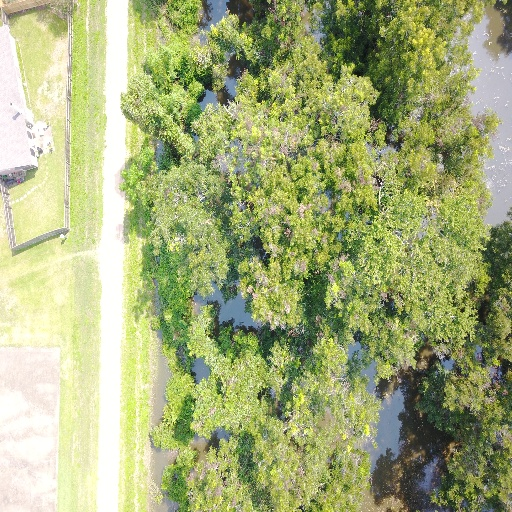

Segmentation Map


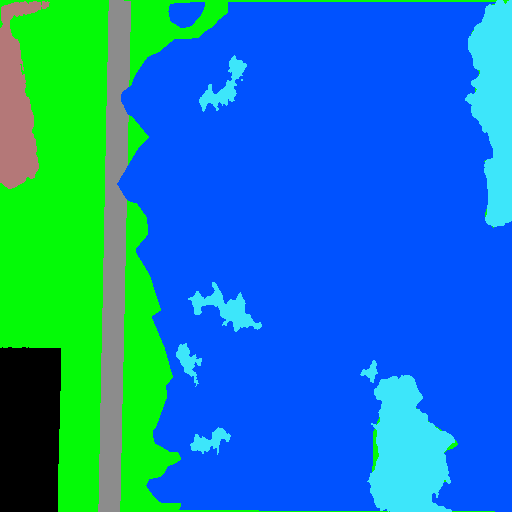

100%|██████████| 20/20 [00:01<00:00, 16.80it/s]

Predicted Image
<PIL.Image.Image image mode=RGB size=512x512 at 0x1551BD94E390>


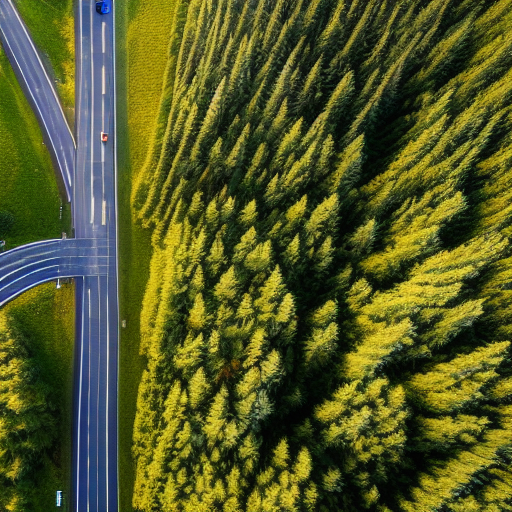

In [9]:
visualize_image(0,train_dataset)